# Tidally Filtered Satellite Composites

### Background
The intertidal zones across Australia possess significant environmental value, and provide a host of ecosystem services that are often poorly valued. However, mapping the extent of the major intertidal land classes (e.g. mangroves, salt marsh, clay pans) is a difficult challenge given the vast extent of Australia's coastline.  The Sentinel 2 archive in Digital Earth Australia's datacube provides a means to map the intertidal zone at scale by providing complete satellite coverage of Australia at 10m spatial resolution and a 3-5 day return time. 

### Description
For mapping the extent of mangroves, salt marsh, and clay-pans in the intertidal zone we need annual composites of the mid-tide conditions to reduce noise from water inundation. This notebook will load in Sentinel 2 data from the datacube, calculate the tide height at the time of each satellite observation, and then create an image composite of only those satellite images that are within a specified tidal range. The code will also produce a number of vegetation indice summary statistics (the `Modified Soil Adjusted Vegetation Index, MSAVI`: max, min, std dev, and range), along with a map of indundation frequency, to assist in the classification script `RandomForest_classifier.ipynb`.  The workflow is as follows:  

1.  Load in a Sentinel 2 time-series, and cloud mask using a prototype time-series based cloud mask.
2.  Calculate the tide height for each satellite image. 
3.  Filter the images by the tidal range that encompasses the mid-tide height.
4.  Calculate summary phenology statistics on `MSAVI`, and calculate the mean `Modified, Normalised Difference Water Index (MNDWI)`.
5.  Calculate normalised inundation frequency using MNDWI.
6.  Create annual geomedian composite images of the spectral bands. 
7.  Join the phenology summary stats and the spectral geomedians together and export the results as a netcdf file.
8.  Export a true and false colour geotiff to assist with creating a training dataset.

### Technical details

* Products used: `s2a_ard_granule`, `s2b_ard_granule`
* Analyses used: `tide modelling`, `image compositing: Geomedians` `MSAVI` `MNDWI`

### Getting Started

Before this notebook can run on the Sandbox, the `RF_classifier.py` script needs to be placed in the working folder:
 
You also need to install a few libraries that aren't by default installed on the DEA Sandbox.  Run the cell below to load in the libraries (you only need to do this once, thereafter the libraries will be available). Once you've successfully run the installation, you will need to restart the kernel before the libraries will work.  Click `kernel--> Restart kernel and clear all outputs`.

Delete the cell below once you've successfully installed the libraries


In [ ]:
#Install non-default libaraies
# !pip install --user git+https://github.com/opendatacube/datacube-stats/
# !pip install --user hdmedians
# !pip install --user spectral


 **Once you have successful installed the non-default libraries, run this analysis by running all the cells in the notebook (shift+enter will run a highlighted cell), starting with the "Load modules" cell.**

### Load modules

In [1]:
#load datacube related modules
import datacube
import datacube_stats
from datacube_stats.statistics import GeoMedian
from datacube.storage.masking import make_mask
import hdstats
import odc.algo
from datacube.utils.dask import start_local_dask
from dask.utils import parse_bytes
from datacube.utils.rio import configure_s3_access
from datacube.helpers import write_geotiff

#load python modules
import warnings
import dask
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

#Import DEA Notebooks scripts
sys.path.append('../Scripts')
import dea_datahandling
import dea_coastaltools
from dea_plotting import display_map
from dea_bandindices import calculate_indices
warnings.simplefilter(action='ignore', category=FutureWarning)

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

### Set up a dask local cluster

In [22]:
# configure dashboard link to go over proxy
dask.config.set({"distributed.dashboard.link":
                 os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

# Figure out how much memory/cpu we really have (those are set by jupyterhub)
mem_limit = int(os.environ.get('MEM_LIMIT', '0'))
mem_limit = mem_limit if mem_limit > 0 else parse_bytes('8Gb')
mem_limit -= parse_bytes('2Gb') # leave 2Gb for notebook itself

# close previous client if any, so that one can re-run this cell without issues
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = start_local_dask(n_workers=1,
                          threads_per_worker=4, 
                          memory_limit=mem_limit)

# Configure GDAL for s3 access 
configure_s3_access(aws_unsigned=True,  # works only when reading public resources
                    client=client)

display(client)

Client Scheduler: tcp://127.0.0.1:44503 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 15.18 GB


## User inputs to set up analysis

The following lines allow us to set up our analysis by selecting the location (`lat_range` and `lon_range`) and time (`time_range`) we want to investigate.

* **lat:** Latitude of the central point in your AOI (e.g. `-12.20`).

* **lon:** Longitude of the central point in your AOI (e.g. `131.80`). 

* **buffer:** The distance (in decimal degrees) around your central lat/lon point. For fast load times, keep this < 0.04 degrees.

* **time_range:** Enter a year to collect data from (just do one year at a time e.g. `'2018'` )

* **tide_lat/lon:** The tidal model used in this analysis can only model tide heights correctly if the centre of your study area is located over open ocean. To avoid having the model fail, specify a tide modelling location that is over the open ocean nearest to the AOI you want to investigate. 

* **tide_range_buffer:** A buffer value (in metres, e.g `0.3`) is required to stipulate what range of tidal values should be collected to allow for image compositing of the mid-tide conditions (buffer value is centred around 0m, ie.e Mean Sea Level at that location). A greater number will include more images in the image compositing algorithm, but at the cost of intergrating greater variation of tidal conditions into the image.

### Edit these lines to change any of the analysis parameters

In [6]:
lat = -27.7476 #-27.651  
lon = 153.3907 #153.33 

buffer = 0.02

time_range = '2018'

tide_lat = -27.651
tide_lon = 153.33

tide_range_buffer = 0.3

#set a location and name to put the results
results = 'results/'
savefilename = 'eden_allSummaryStats'

### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [17]:
# display_map(y=(lat-buffer, lat + buffer), x=(lon-buffer, lon + buffer))

## Load cloud-masked Sentinel 2 data
The first step in this analysis is to load in cloud-masked Sentinel 2 data for the `lat_range`, `lon_range` and `time_range` we provided above. We will be doing this using a protoype time-series based cloud masking approach (the algorithm looks for outliers).

In [8]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
dc = datacube.Datacube(app='tidallyfilteredcomposites')

query = {
    'y':(lat-buffer, lat+buffer),
    'x': (lon-buffer, lon+buffer),
    'time': (time_range),
    'dask_chunks' : {'x':200, 'y':200},
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

In [9]:
#load in the sentinel Time Series mask
print('loading TSmask')
tsmask_ds = dc.load(product='s2_tsmask', **query)

# Load in Sentinel-2A and 2B data, just the optical bands
bands = ['nbart_blue','nbart_green',
         'nbart_red','nbart_red_edge_1',
         'nbart_red_edge_2','nbart_red_edge_3',
         'nbart_nir_1','nbart_nir_2',
         'nbart_swir_2','nbart_swir_3']

query['measurements'] = bands
sentinel_ds = dea_datahandling.load_ard(dc=dc,
                                        lazy_load=True,
                                        mask_pixel_quality=False,
                                        mask_invalid_data=False,
                                        products=['s2a_ard_granule',
                                                  's2b_ard_granule'],
                                        **query)

# Return only observations that have timesteps in both datasets
matching_times = (tsmask_ds.time - sentinel_ds.time).time
tsmask_ds = tsmask_ds.sel(time=matching_times)
sentinel_ds = sentinel_ds.sel(time=matching_times)

# mask S2 with cloud mask
cloud_free_mask = make_mask(tsmask_ds.classification, classification='valid')
sentinel_ds = sentinel_ds.where(cloud_free_mask)
print(sentinel_ds)

loading TSmask
Loading s2a_ard_granule data
Loading s2b_ard_granule data
Combining and sorting data
    Returning 137 observations as a dask array
<xarray.Dataset>
Dimensions:           (time: 137, x: 460, y: 509)
Coordinates:
  * y                 (y) float64 -3.182e+06 -3.182e+06 ... -3.187e+06
  * x                 (x) float64 2.071e+06 2.071e+06 ... 2.076e+06 2.076e+06
  * time              (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-12-31T00:02:39.024000
Data variables:
    nbart_blue        (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_green       (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red         (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red_edge_1  (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red_edge_2  (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 20

## Calculate band indices

In [10]:
sentinel_ds = calculate_indices(sentinel_ds, index=['MSAVI', 'MNDWI'], collection='ga_s2_1')

## Model tide heights
As mangroves are in the inter-tidal zone, we aim to reduce the effect of tides by first modelling the tide height, and then keeping only the satellite images that were taken at the mid-tide conditions. For example, if `tide_range_buff = 0.3`, we are telling the analysis to focus only on satellite images taken when the tide was between `-0.30 m` and `+0.30 m` of the MSL.

The `tidal_tag` function below uses the [OTPS TPXO9 tidal model](http://volkov.oce.orst.edu/tides/global.html) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_height` attribute in our dataset. 

In [11]:
sentinel_ds = dea_coastaltools.tidal_tag(
    ds=sentinel_ds,
    tidepost_lat=tide_lat,
    tidepost_lon=tide_lon
)
sentinel_ds

Using user-supplied tide modelling location: 153.33, -27.65


<xarray.Dataset>
Dimensions:           (time: 137, x: 460, y: 509)
Coordinates:
  * y                 (y) float64 -3.182e+06 -3.182e+06 ... -3.187e+06
  * x                 (x) float64 2.071e+06 2.071e+06 ... 2.076e+06 2.076e+06
  * time              (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-12-31T00:02:39.024000
Data variables:
    nbart_blue        (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_green       (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red         (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red_edge_1  (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red_edge_2  (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_red_edge_3  (time, y, x) float64 dask.array<shape=(137, 509, 460), chunksize=(1, 200, 200)>
    nbart_nir_1       (time, y, x) float6

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Sentinel across our time series. In the plot below, red dashed lines also show the subset of the tidal range we selected using the `tide_range_buffer` parameter.

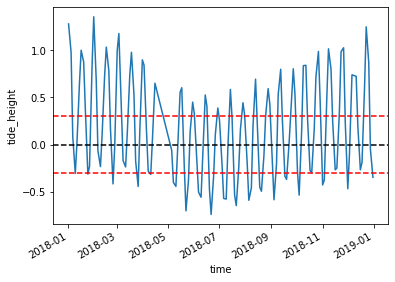

In [12]:
# Plot the resulting tide heights for each sentinel image:
tide_range = (0-tide_range_buffer, 0+tide_range_buffer)

sentinel_ds.tide_height.plot()
plt.axhline(0, c='black', linestyle='--')
plt.axhline(tide_range[0], c='red', linestyle='--')
plt.axhline(tide_range[1], c='red', linestyle='--')
plt.show()

### Filter Sentinel images by tide height
Here we take the Sentinel 2 dataset and only keep the images within the tide heights given by `tide_range_buffer`.

In [13]:
sentinel_filtered_all = sentinel_ds.where((sentinel_ds.tide_height > tide_range[0]) & 
                                    (sentinel_ds.tide_height < tide_range[1]), drop=True)

print("We retained "+ str(len(sentinel_filtered_all.time.values)) + " images from within the nominated mid-tide range")

We retained 51 images from within the nominated mid-tide range


In [14]:
# Now compute all of the calculations we have done up to this point.
# This will be slow
sentinel_filtered_all = sentinel_filtered_all.compute()

# Calculate summary phenology statistics

These will help in our random forest classifier with distinguishing the different classes

In [15]:
#vegetation indice summary statistics
msavi_mean = sentinel_filtered_all.MSAVI.mean('time').rename('msavi_mean')
msavi_std = sentinel_filtered_all.MSAVI.std('time').rename('msavi_std')
msavi_min = sentinel_filtered_all.MSAVI.min('time').rename('msavi_min')
msavi_max = sentinel_filtered_all.MSAVI.max('time').rename('msavi_max')
msavi_range = msavi_max - msavi_min
msavi_range = msavi_range.rename('msavi_range')

#and seperate out a mean of our water index
mndwi_mean = sentinel_filtered_all.MNDWI.max('time').rename('mndwi_mean')

## Calculate inundation frequency

This will calculate the frequency with which each pixel is inundated with water (inundation is defined as times when MNDWI indice is > 0).

Frequency is defined as the number of times a pixel is observed as water divided by the number of valid observations of the pixel.

In [16]:
#Where MNDWI is > 0 (is water), convert to boolean
water = sentinel_ds.MNDWI > 0
#count the number of times we observe water per pixel
count = water.sum(dim=['time'])
#count number of valid observations per pixel
valid_ds = np.isfinite(sentinel_ds.nbart_red)
valid_sum = valid_ds.sum(dim=['time'])
#calcuate normalised inundation frequency
frequency = (count / valid_sum)
frequency = frequency.rename('inundation_freq')
frequency = frequency.compute()


## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period.  In the code below, we take the tidally filtered set of images and calculate an annual [Geomedian](https://github.com/daleroberts/hdmedians). A geomedian calculates a high-dimensional median value for each pixel, for each spectral band. In contrast to a standard median, a geomedian maintains the relationship between spectral bands. This allows us to conduct further analysis on the composite images just as we would on the original satellite images.

### GeoMedian composite

This will take a couple of minutes to run

In [18]:
#compute annual geomedians from the entire mid-tide range for only the spectral bands
sentinel_geomedian = GeoMedian().compute(sentinel_filtered_all.drop(['tide_height', 'MSAVI', 'MNDWI']))

### Combine our phenology stats with geomedians into a single object

In [19]:
allSummaryStats = xr.merge([sentinel_geomedian,msavi_mean,msavi_std,
                            msavi_min,msavi_max,msavi_range,mndwi_mean,frequency])

allSummaryStats.attrs = sentinel_ds.attrs


In [20]:
print(allSummaryStats)

<xarray.Dataset>
Dimensions:           (x: 460, y: 509)
Coordinates:
  * y                 (y) float64 -3.182e+06 -3.182e+06 ... -3.187e+06
  * x                 (x) float64 2.071e+06 2.071e+06 ... 2.076e+06 2.076e+06
Data variables:
    nbart_blue        (y, x) float64 621.7 549.1 438.6 ... 533.6 485.4 500.4
    nbart_green       (y, x) float64 709.1 621.5 521.2 ... 616.7 543.4 555.7
    nbart_red         (y, x) float64 660.4 603.7 460.4 ... 526.6 426.4 446.2
    nbart_red_edge_1  (y, x) float64 675.8 674.2 673.5 ... 557.7 649.0 651.8
    nbart_red_edge_2  (y, x) float64 532.4 989.7 989.7 ... 605.2 710.2 714.1
    nbart_red_edge_3  (y, x) float64 559.3 1.097e+03 1.092e+03 ... 794.6 797.7
    nbart_nir_1       (y, x) float64 569.3 711.2 1.02e+03 ... 838.5 402.4 435.0
    nbart_nir_2       (y, x) float64 506.5 1.192e+03 1.187e+03 ... 819.8 824.7
    nbart_swir_2      (y, x) float64 262.2 524.0 516.0 ... 388.3 479.9 482.1
    nbart_swir_3      (y, x) float64 183.0 275.3 268.6 ... 229.5 2

### Export our results as a netcdf

This file will be our input into the random forest classifier

In [21]:
datacube.drivers.netcdf.write_dataset_to_netcdf(allSummaryStats, results + savefilename +'.nc')


### Export a true and false colour geotiff to assist with creating a training dataset

When creating a training dataset, it's important to use the same imagery that will be used in classifier, rather than relying on image composites provided in google maps or esri basemaps as these will be from different time periods.

In [ ]:
#select just the rgb bands for the true colour geotiff
rgb = xr.merge([sentinel_geomedian.nbart_red, sentinel_geomedian.nbart_green, sentinel_geomedian.nbart_blue])
rgb.attrs = sentinel_geomedian.attrs

#select the swir, nir, and green bands for the false colour image
sng = xr.merge([sentinel_geomedian.nbart_swir_2, sentinel_geomedian.nbart_nir_1, sentinel_geomedian.nbart_green])
sng.attrs = sentinel_geomedian.attrs

#write out the results
write_geotiff(results+'true_colour.tif', rgb)
write_geotiff(results+'false_colour.tif', sng)

In [ ]:
#plot to check out the geomdian geotiffs look right
b=['nbart_red','nbart_green', 'nbart_blue']
da = rgb[b].to_array()
img = da.plot.imshow(robust=True)



#### That completes this script, now open `RandomForest_classifier.ipynb` to use the tidally filtered composites we just created to classify the intertidal zone in you're AOI